Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✔️ Base cargada: 52,505 filas después de eliminar duplicados

📊 Distribución de clases:
RQ
RQ=0    0.866451
RQ=1    0.133549
Name: proportion, dtype: float64


Random Forest CV: 100%|██████████| 10/10 [05:26<00:00, 32.69s/it]


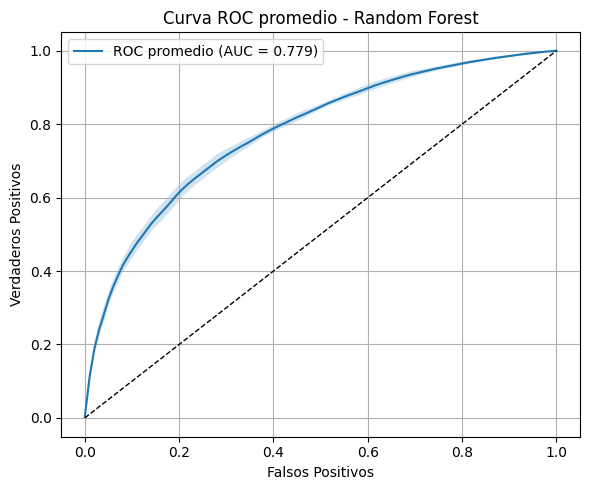

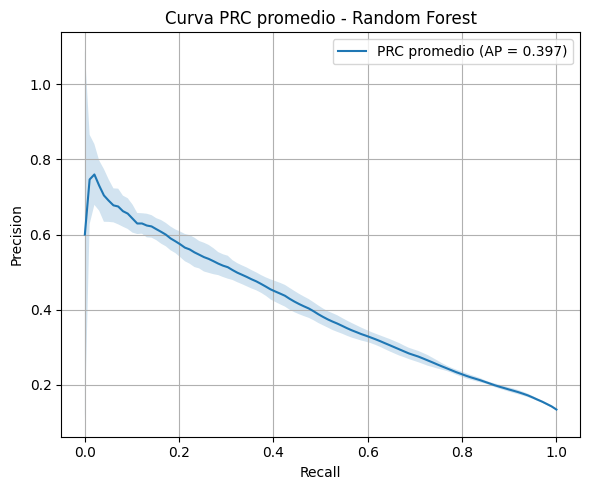


📁 Resumen comparativo actualizado: /content/drive/MyDrive/Resultados/resultados_comparativos_modelos_turismo.csv


In [2]:
# 13_3: Random Forest sin SMOTE (Base Turismo Reducida)
# =======================================================

# 🚗 Montar Drive
from google.colab import drive
drive.mount('/content/drive')

# 🔐 Replicabilidad
import random
import numpy as np
random.seed(42)
np.random.seed(42)

# 📚 Librerías principales
import pandas as pd
import os, gc
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, log_loss,
    roc_curve, precision_recall_curve, average_precision_score
)
import matplotlib.pyplot as plt

# 📍 Rutas
ruta_base = "/content/drive/MyDrive/Datos/7_Base_Modelos_Predictivos_Reducida.parquet"
ruta_csv_importancia = "/content/drive/MyDrive/Resultados/13_3_Importancias_RF_Turismo.csv"
ruta_graf_roc = "/content/drive/MyDrive/Resultados/13_3_Curva_ROC_RF_Turismo.png"
ruta_graf_prc = "/content/drive/MyDrive/Resultados/13_3_Curva_PRC_RF_Turismo.png"
ruta_resumen = "/content/drive/MyDrive/Resultados/resultados_comparativos_modelos_turismo.csv"

# 📊 Cargar base
df = pd.read_parquet(ruta_base).drop_duplicates()
print(f"✔️ Base cargada: {df.shape[0]:,} filas después de eliminar duplicados")

# 🎯 Variables
y = df["RQ"]
X = df.drop(columns=["RQ", "NIT", "DEP", "CIIU_Letra"])
X = X.replace([np.inf, -np.inf], 1e6)  # 🧼 Control de infinitos


# ⚖️ Distribución de clases
print("\n📊 Distribución de clases:")
print(y.value_counts(normalize=True).rename(lambda x: f"RQ={x}"))

# 🔄 Validación cruzada
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# 🔢 Inicializar
resultados, importancias, roc_curves, prc_curves = [], [], [], []
loglosses, aucs, y_true_total, y_prob_total = [], [], [], []

for i, (train_idx, test_idx) in enumerate(tqdm(skf.split(X, y), total=10, desc="Random Forest CV"), start=1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model = RandomForestClassifier(
        n_estimators=100, random_state=42, class_weight='balanced'
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    resultados.append([
        accuracy_score(y_test, y_pred),
        precision_score(y_test, y_pred),
        recall_score(y_test, y_pred),
        f1_score(y_test, y_pred)
    ])
    loglosses.append(log_loss(y_test, y_prob))
    aucs.append(roc_auc_score(y_test, y_prob))

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    roc_curves.append((fpr, tpr))
    prc_curves.append((recall, precision))

    y_true_total.extend(y_test)
    y_prob_total.extend(y_prob)

    # Importancia de variables
    imp = pd.Series(model.feature_importances_, index=X.columns)
    importancias.append(imp)

    del X_train, X_test, y_train, y_test, y_pred, y_prob, model
    gc.collect()

# 📊 Métricas finales
resultados_np = np.array(resultados)
metrics_mean = resultados_np.mean(axis=0)
metrics_std = resultados_np.std(axis=0)
logl_mean, logl_std = np.mean(loglosses), np.std(loglosses)
auc_mean, auc_std = np.mean(aucs), np.std(aucs)

# 🔝 Top 3 variables
df_importancias = pd.concat(importancias, axis=1)
df_importancias.columns = [f'Fold_{i}' for i in range(1, 11)]
df_importancias["mean"] = df_importancias.mean(axis=1)
top_vars = df_importancias["mean"].sort_values(ascending=False).head(3).index.tolist()
top1, top2, top3 = (top_vars + [None]*3)[:3]
df_importancias.to_csv(ruta_csv_importancia)

# 📈 Curva ROC promedio
fpr_interp = np.linspace(0, 1, 100)
tprs = [np.interp(fpr_interp, fpr, tpr) for fpr, tpr in roc_curves]
tpr_mean, tpr_std = np.mean(tprs, axis=0), np.std(tprs, axis=0)

plt.figure(figsize=(6, 5))
plt.plot(fpr_interp, tpr_mean, label=f'ROC promedio (AUC = {auc_mean:.3f})')
plt.fill_between(fpr_interp, tpr_mean - tpr_std, tpr_mean + tpr_std, alpha=0.2)
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('Falsos Positivos')
plt.ylabel('Verdaderos Positivos')
plt.title('Curva ROC promedio - Random Forest')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(ruta_graf_roc)
plt.show()

# 📈 Curva PRC promedio
recall_interp = np.linspace(0, 1, 100)
precisions = [np.interp(recall_interp, r[::-1], p[::-1]) for r, p in prc_curves]
prec_mean, prec_std = np.mean(precisions, axis=0), np.std(precisions, axis=0)

plt.figure(figsize=(6, 5))
plt.plot(recall_interp, prec_mean, label=f'PRC promedio (AP = {average_precision_score(y_true_total, y_prob_total):.3f})')
plt.fill_between(recall_interp, prec_mean - prec_std, prec_mean + prec_std, alpha=0.2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva PRC promedio - Random Forest')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(ruta_graf_prc)
plt.show()

# 🧾 Guardar/Actualizar resumen comparativo
if os.path.exists(ruta_resumen):
    resumen_modelos = pd.read_csv(ruta_resumen)
    if 'Observación' in resumen_modelos.columns:
        resumen_modelos = resumen_modelos.drop(columns='Observación')
else:
    columnas = [
        'Base', 'Modelo', 'Naturaleza', 'Temporalidad', 'Tipo de aprendizaje',
        'Accuracy', 'Desv. Accuracy',
        'Precision', 'Desv. Precision',
        'Recall', 'Desv. Recall',
        'F1-score promedio', 'Desviación F1',
        'AUC', 'Desv. AUC',
        'LogLoss', 'Desv. LogLoss',
        'Top 1 variable', 'Top 2 variable', 'Top 3 variable'
    ]
    resumen_modelos = pd.DataFrame(columns=columnas)

mask = (resumen_modelos['Base'] == 'Turismo') & (resumen_modelos['Modelo'] == 'Random Forest')
idx = resumen_modelos[mask].index[0] if not resumen_modelos[mask].empty else len(resumen_modelos)

resumen_modelos.loc[idx] = [
    'Turismo', 'Random Forest', 'Avanzado', 'Estática', 'Supervisado',
    round(metrics_mean[0], 4), round(metrics_std[0], 4),
    round(metrics_mean[1], 4), round(metrics_std[1], 4),
    round(metrics_mean[2], 4), round(metrics_std[2], 4),
    round(metrics_mean[3], 4), f"±{metrics_std[3]:.4f}",
    round(auc_mean, 4), round(auc_std, 4),
    round(logl_mean, 4), round(logl_std, 4),
    top1, top2, top3
]

resumen_modelos.to_csv(ruta_resumen, index=False)
print(f"\n📁 Resumen comparativo actualizado: {ruta_resumen}")
